# Evaluate Various Models for CLA Data

## Import Statements

In [1]:
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as utils
from torch.autograd import Variable
import numpy as np
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Tahoma']
import matplotlib.pyplot as plt
%matplotlib inline
import errno
import os
import sys
import copy

## Hyperparameters

In [2]:
sample_bias = 0     # adjust the difference in the number of the two types of samples (no algae vs algae)
test_size = 0.2
num_splits = 10
k = 1   # for k-NN
num_subsets = 10
batch_size = 96    # batch size for the DataLoaders

# NN model
num_features = 17
input_size = num_features     # size of input layer
multiplier = 100              # multiplied by num_features to determine the size of each hidden layer
hidden_size = multiplier * input_size
output_size = 1
learning_rate = 0.001         # learning rate of optimizer. previously was 0.01
num_epochs = 100              # number of epochs

## Read in Data

In [3]:
np.set_printoptions(threshold=np.inf)  # prints a full matrix rather than an abbreviated matrix

# define data and destination paths
dest_path = "/Users/Alliot/Documents/CLA-Project/Data/all-data-no-na/neural-network/"
data_path_hourly = "/Users/Alliot/Documents/CLA-Project/Data/hourly-data-sets/"
# data_path = "/Users/Alliot/Documents/CLA-Project/Data/data-sets/"
# data_set_hourly = "hourly_data_2017"
# data_set = "data_2017_summer"

# # load data sets
# X = np.load(data_path_hourly + data_set_hourly + "_edit.npy")
# y = np.load(data_path_hourly + data_set_hourly + "_labels.npy")
# X = X.astype(float)
# y = y.astype(int)

X_2015 = np.load(data_path_hourly + 'hourly_X_2015.npy')
X_2016 = np.load(data_path_hourly + 'hourly_X_2016.npy')
X_2017 = np.load(data_path_hourly + 'hourly_X_2017.npy')
X_2018 = np.load(data_path_hourly + 'hourly_X_2018.npy')

y_2015 = np.load(data_path_hourly + 'hourly_y_2015.npy')
y_2016 = np.load(data_path_hourly + 'hourly_y_2016.npy')
y_2017 = np.load(data_path_hourly + 'hourly_y_2017.npy')
y_2018 = np.load(data_path_hourly + 'hourly_y_2018.npy')

X = np.vstack((X_2015, X_2016, X_2017, X_2018)).astype(float)
y = np.hstack((y_2015, y_2016, y_2017, y_2018))

num_features = X.shape[1]

# manipulate data set. labels are converted to 0, +1 for binary classification; samples are removed uniformly 
# from the data set so that the disproportionately large number of negative samples (no algae) does 
# not bias the model.

num_alg = 0  # count the number of algae instances
num_no_alg = 0  # count the number of no algae instances

# Convert labels to binary: 0 for no algae and 1 for algae
for i in range(0, len(y)):
    if y[i] == 0:
        num_no_alg += 1
    if y[i] == 1 or y[i] == 2:
        y[i] = 1
        num_alg += 1

# oversample the data set by randomly adding occurences of algae until the difference between the number of algae
# samples and no algae samples equals sample_bias (defined below)
# idx = 0
# sample_bias = 0
# length_y = len(y)
# while num_alg != (num_no_alg + sample_bias):
#     # circle through the data sets until the difference of num_no_alg and num_alg equals
#     # the value specified by sample_bias
#     if idx == (length_y - 1):
#         idx = 0

#     if y[idx] == 1:
#         if np.random.rand() >= 0.5:  # add this sample with some probability
#             y = np.append(y, y[idx])
#             X = np.append(X, np.reshape(X[idx, :], newshape=(1, num_features)), axis=0)
#             num_alg += 1
#         else:
#             idx += 1
#     else:
#         idx += 1

In [4]:
# Shuffle the data
shuff_idx = np.arange(X.shape[0])
np.random.shuffle(shuff_idx)

X = X[shuff_idx, :]
y = y[shuff_idx]

In [5]:
# Read in data for plotting ROC and PR Curves

# k-NN and Logistic Regression
X_train_curve = np.load(dest_path + "X_train_curve.npy")
X_test_curve = np.load(dest_path + "X_test_curve.npy")
y_train_curve = np.load(dest_path + "y_train_curve.npy")
y_test_curve = np.load(dest_path + "y_test_curve.npy")

# Neural Network
train_loader_curve = torch.load(dest_path + "train_loader_curve.pt")
test_loader_curve = torch.load(dest_path + "test_loader_curve.pt")

In [19]:
# determine weight vector for the each class; used in defining some of the models
num_pos = y.tolist().count(0)
weight_pos = 1 / num_pos
num_neg = y.tolist().count(1)
weight_neg = 1 / num_neg
weight = {
    0 : weight_pos,
    1 : weight_neg
}

## Define Models

### SVMs

In [20]:
linear_svc = svm.LinearSVC(
    # penalty="l2",
    # loss="hinge",
    dual=False,
    tol=0.0001,
    C=1,
    fit_intercept=True,
    intercept_scaling=1,
    verbose=False,
    max_iter=1000
)

In [21]:
rbf_svc = svm.SVC(
    C=1000,
    kernel="rbf",
    gamma="auto",
    probability=False,
    shrinking=True,
    tol=0.0001,
    verbose=False,
    max_iter=-1,
)

In [22]:
poly_svc = svm.SVC(
    C=1,
    kernel="poly",
    degree=5,
    gamma="auto",
    coef0=1,
    probability=False,
    shrinking=True,
    tol=0.0001,
    verbose=False,
    max_iter=-1,
)

### Logistic Regression

In [23]:
logistic = LogisticRegression(
#     penalty="l2",
    dual=False,
    tol=0.0001,
    C=1,
    fit_intercept=True,
    intercept_scaling=1,
    class_weight=weight,
    random_state=None,
    solver="liblinear",
    max_iter=1000,
    verbose=False,
    warm_start=False
)

### Least Squares

In [24]:
# X_LS = np.concatenate((X, np.ones(shape=(X.shape[0], 1))), axis=1)   # column of ones for offset
# lamb = 0   # L2 regularization

### K-Nearest Neighbors

In [25]:
knn = KNeighborsClassifier(
    n_neighbors=k,
    weights="uniform",
    algorithm="brute",
    p=2,
    metric="minkowski",
    n_jobs=None
)

### Neural Network

In [26]:
class CLANet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CLANet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.tanh2 = nn.Tanh()
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.tanh4 = nn.Tanh()
        self.fc5 = nn.Linear(hidden_size, hidden_size)
        self.relu5 = nn.ReLU()
        self.fc6 = nn.Linear(hidden_size, output_size)
        self.sig1 = nn.Sigmoid()
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.tanh2(out)
        out = self.fc3(out)
        out = self.relu3(out)
        out = self.fc4(out)
        out = self.tanh4(out)
        out = self.fc5(out)
        out = self.relu5(out)
        out = self.fc6(out)
        out = self.sig1(out)
        return out

In [27]:
model = CLANet(input_size, hidden_size, output_size)
model.load_state_dict(torch.load(dest_path + "torch_model_4_6_19_lr=0.001_dict.pt"))
model.double()     # cast model parameters to double
model.eval();

## Run Models

In [28]:
# Perform 10-fold CV on all models
skf = model_selection.StratifiedKFold(n_splits=num_splits, shuffle=False)

linear_svc_acc = [0] * num_subsets
rbf_svc_acc = [0] * num_subsets
poly_svc_acc = [0] * num_subsets
logistic_acc = [0] * num_subsets
# LS_acc = [0] * num_subsets
knn_acc = [0] * num_subsets

fold = 1
print("Fold #: ", end=" ")

for train_idx, test_idx in skf.split(X, y):
    print(str(fold), end=" ")
    X_train, X_test = X[train_idx, :], X[test_idx, :]
    y_train, y_test = y[train_idx], y[test_idx]
    
#     length_y_train = len(y_train)
#     num_no_alg = 0
#     num_alg = 0
    
    # count number of labels
#     for i in range(0, length_y_train):
#         if y_train[i] == 0:
#             num_no_alg += 1
#         if y_train[i] == 1:
#             num_alg += 1
    
    # oversample the data set by randomly adding occurences of algae until the difference between the number of algae
    # samples and no algae samples equals sample_bias (defined in hyperparameters section)
#     idx = 0
#     while num_alg != (num_no_alg + sample_bias):
#         # circle through the data sets until the difference of num_no_alg and num_alg equals
#         # the value specified by sample_bias
#         if idx == (length_y_train-1):
#             idx = 0

#         if y_train[idx] == 1:
#             if np.random.rand() >= 0.5:  # add this sample with some probability
#                 y_train = np.append(y_train, y_train[idx])
#                 X_train = np.append(X_train, np.reshape(X_train[idx, :], newshape=(1, num_features)), axis=0)
#                 num_alg += 1
#             else:
#                 idx += 1
#         else:
#             idx += 1
            
#     # randomly shuffle training set
#     train_perm = np.random.permutation(np.arange(X_train.shape[0]))
#     X_train = X_train[train_perm, :]
#     y_train = y_train[train_perm]
    
#     X_LS_train, X_LS_test = X_LS[train_idx, :], X_LS[test_idx, :]   # for least squares
    
    X_train = preprocessing.scale(X_train, axis=1, with_mean=True, with_std=True)
    X_test = preprocessing.scale(X_test, axis=1, with_mean=True, with_std=True)
    
#     X_LS_train = preprocessing.scale(X_LS_train, axis=1, with_mean=True, with_std=True)
#     X_LS_test = preprocessing.scale(X_LS_test, axis=1, with_mean=True, with_std=True)
    
    for i in range(num_subsets):
        sub_idx = int(np.floor(((i+1) * X_train.shape[0])) / float(num_subsets))
        X_train_sub = X_train[:sub_idx, :]
#         X_LS_train_sub = X_LS_train[:sub_idx, :]
        
        y_train_sub = y_train[:sub_idx]
        
        # SVMs
#         linear_svc.fit(X_train_sub, y_train_sub)
#         linear_svc_pred = linear_svc.predict(X_test)

#         rbf_svc.fit(X_train_sub, y_train_sub)
#         rbf_svc_pred = rbf_svc.predict(X_test)

#         poly_svc.fit(X_train_sub, y_train_sub)
#         poly_svc_pred = poly_svc.predict(X_test)

        # logistic
        logistic.fit(X_train_sub, y_train_sub)
        logistic_pred = logistic.predict(X_test)
        logistic_prob = logistic.predict_proba(X_test)[:, 1]

        # least squares
#         a = np.transpose(X_LS_train_sub)
#         b = np.matmul(a, X_LS_train_sub)
#         f = np.multiply(lamb, np.identity(b.shape[0]))
#         e = b + f
#         c = np.linalg.inv(e)
#         d = np.matmul(c, a)
#         w = np.matmul(d, y_train_sub)   # weight vector

#         LS_pred = np.matmul(X_LS_test, w)
#         LS_pred = np.sign(LS_pred)

        # knn
#         knn.fit(X_train_sub, y_train_sub)
#         knn_pred = knn.predict(X_test)
#         knn_prob = knn.predict_proba(X_test)[:, 1]

        # accuracy calculation
#         linear_svc_acc[i] += (np.sum(linear_svc_pred == y_test) / len(y_test))
#         rbf_svc_acc[i] += (np.sum(rbf_svc_pred == y_test) / len(y_test))
#         poly_svc_acc[i] += (np.sum(poly_svc_pred == y_test) / len(y_test))
        logistic_acc[i] += (np.sum(logistic_pred == y_test) / len(y_test))
#         LS_acc[i] += 1 - (np.sum(LS_pred == y_test) / len(y_test))
#         knn_acc[i] += (np.sum(knn_pred == y_test) / len(y_test))
    
    fold += 1
        
# linear_svc_acc[:] = [float(i) / float(num_splits) for i in linear_svc_acc]
# rbf_svc_acc[:] = [float(i) / float(num_splits) for i in rbf_svc_acc]
# poly_svc_acc[:] = [float(i) / float(num_splits) for i in poly_svc_acc]
logistic_acc[:] = [float(i) / float(num_splits) for i in logistic_acc]
# LS_acc[:] = [float(i) / float(num_splits) for i in LS_acc]
# knn_acc[:] = [float(i) / float(num_splits) for i in knn_acc]

Fold #:  1 2 3 4 5 6 7 8 9 10 

## Plot Results

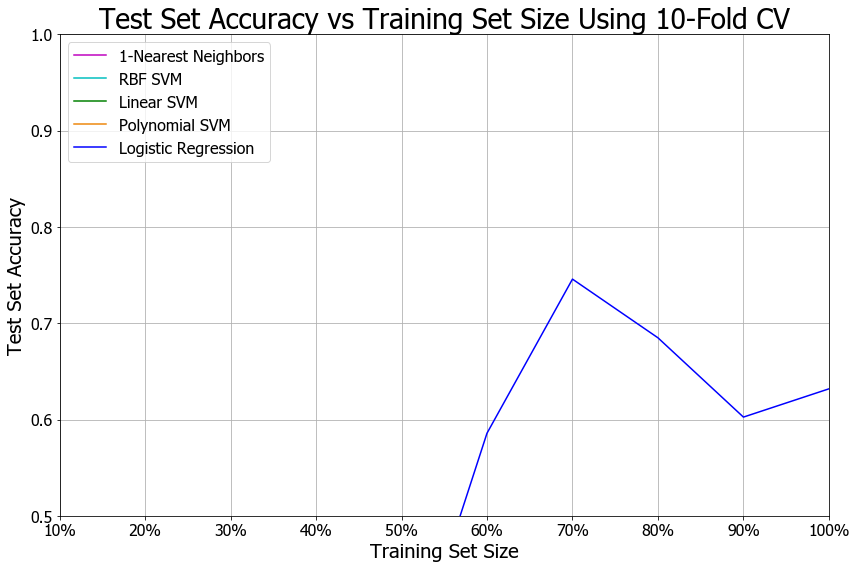

In [29]:
folds = [i+1 for i in range(num_splits)]

plt.figure(figsize=(12, 8))
plt.plot(folds, knn_acc, color="m", label=str(k) + "-Nearest Neighbors")
plt.plot(folds, rbf_svc_acc, color="c", label="RBF SVM")
plt.plot(folds, linear_svc_acc, color="g", label="Linear SVM")
plt.plot(folds, poly_svc_acc, color="#ed870b", label="Polynomial SVM")
plt.plot(folds, logistic_acc, color="b", label="Logistic Regression")
# plt.plot(folds, LS_acc, color="r", label="Least Squares")
plt.xlabel("Training Set Size", fontsize=20)
plt.xticks(np.arange(num_subsets)+1, ("10%", "20%", "30%", "40%", "50%", "60%", "70%", "80%", "90%", "100%"), fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel("Test Set Accuracy", fontsize=20)
plt.title("Test Set Accuracy vs Training Set Size Using 10-Fold CV", fontsize=28)
plt.axis([1, num_splits, 0.5, 1])
plt.legend(loc="upper left", prop={"size": 16})
plt.tight_layout()
plt.grid(True)
plt.savefig("learning-curve.png", dpi=300)

## ROC and PR Curves

In [17]:
# Make predictions on allocated data sets
knn.fit(X_train_curve, y_train_curve)
knn_prob = knn.predict_proba(X_test_curve)[:, 1]

logistic.fit(X_train_curve, y_train_curve)
logistic_prob = logistic.predict_proba(X_test_curve)[:, 1]

for i, (samples, labels) in enumerate(test_loader_curve):
    samples = Variable(samples)
    labels = Variable(labels)
    conf = model(samples)    # confidence that a certain instance is predicted correctly
    conf = torch.flatten(conf)
    labels = labels.type(torch.DoubleTensor)
    
# convert to numpy arrays
conf = conf.detach().numpy()
labels = labels.numpy()

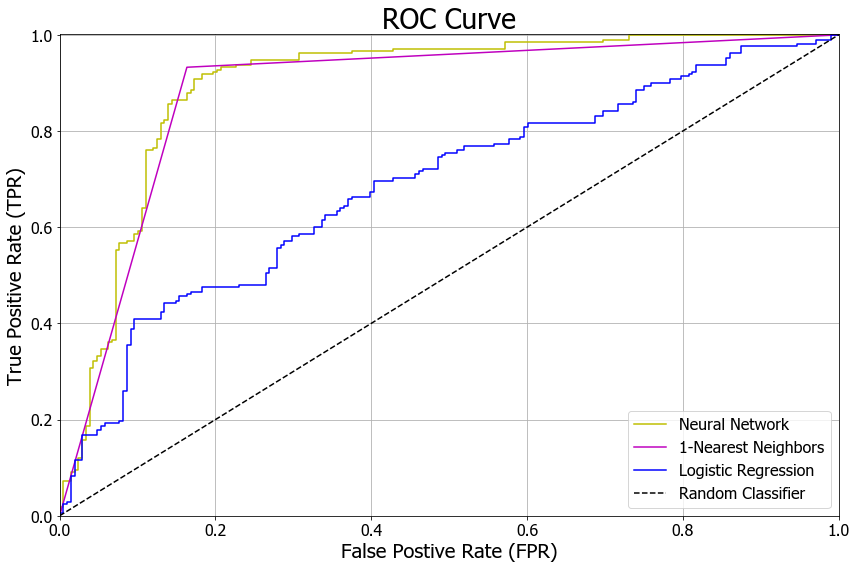

In [18]:
net_fpr, net_tpr, _ = roc_curve(labels, conf, pos_label=1)
knn_fpr, knn_tpr, _ = roc_curve(y_test_curve, knn_prob, pos_label=1)
logistic_fpr, logistic_tpr, _ = roc_curve(y_test_curve, logistic_prob, pos_label=1)

plt.figure(figsize=(12, 8))
plt.plot(net_fpr, net_tpr, color="y", label="Neural Network")
plt.plot(knn_fpr, knn_tpr, color="m", label=str(k) + "-Nearest Neighbors")
plt.plot(logistic_fpr, logistic_tpr, "b", label="Logistic Regression")
plt.plot(0.1*np.arange(12), 0.1*np.arange(12), color="k", linestyle="dashed", label="Random Classifier")
plt.xlabel("False Postive Rate (FPR)", fontsize=20)
plt.ylabel("True Positive Rate (TPR)", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.axis([0, 1, 0, 1.001])
plt.title("ROC Curve", fontsize=28)
plt.legend(loc="lower right", prop={"size": 16})
plt.tight_layout()
plt.grid(True)
plt.savefig("roc-curve.png", dpi=300)

In [ ]:
print("AUC Scores:")
print("\tNeural Networks:", roc_auc_score(labels, conf))
print("\tk-NN:", roc_auc_score(y_test_curve, knn_prob))
print("\tLogistic Regression:", roc_auc_score(y_test_curve, logistic_prob))

## PR Curve

In [ ]:
net_prec, net_recall, _ = precision_recall_curve(labels, conf, pos_label=1)
knn_prec, knn_recall, _ = precision_recall_curve(y_test_curve, knn_prob, pos_label=1)
logistic_prec, logistic_recall, _ = precision_recall_curve(y_test_curve, logistic_prob, pos_label=1)

plt.figure(figsize=(12, 8))
plt.plot(net_prec, net_recall, color="y", label="Neural Network")
plt.plot(knn_prec, knn_recall, color="m", label=str(k) + "-Nearest Neighbors")
plt.plot(logistic_prec, logistic_recall, "b", label="Logistic Regression")
plt.xlabel("Precision", fontsize=20)
plt.ylabel("Recall", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.axis([0, 1, 0, 1.001])
plt.title("PR Curve", fontsize=28)
plt.legend(loc="lower left", prop={"size": 16})
plt.tight_layout()
plt.grid(True)
plt.savefig("pr-curve.png", dpi=300)

## Make Predictions on Past Years

### Read in Data

In [ ]:
np.set_printoptions(threshold=np.inf)  # prints a full matrix rather than an abbreviated matrix

# define data and destination paths
dest_path = "/Users/Alliot/Documents/CLA-Project/Data/all-data-no-na/neural-network/"
data_path_hourly = "/Users/Alliot/Documents/CLA-Project/Data/hourly-data-sets/"
data_path = "/Users/Alliot/Documents/CLA-Project/Data/data-sets/"
data_set_hourly = "hourly_data_2016"
data_set = "data_2016_summer"

# load data sets
X = np.load(data_path + data_set + ".npy")
y = np.load(data_path + data_set + "_labels.npy")
X = X.astype(float)
y = y.astype(int)

num_features = X.shape[1]

# manipulate data set. labels are converted to 0, +1 for binary classification; samples are removed uniformly 
# from the data set so that the disproportionately large number of negative samples (no algae) does 
# not bias the model.

num_alg = 0  # count the number of algae instances
num_no_alg = 0  # count the number of no algae instances

# Convert labels to binary: 0 for no algae and 1 for algae
for i in range(0, len(y)):
    if y[i] == 0:
        num_no_alg += 1
    if y[i] == 1 or y[i] == 2:
        y[i] = 1
        num_alg += 1

# oversample the data set by randomly adding occurences of algae until the difference between the number of algae
# samples and no algae samples equals sample_bias (defined below)
idx = 0
sample_bias = 0
length_y = len(y)
while num_alg != (num_no_alg + sample_bias):
    # circle through the data sets until the difference of num_no_alg and num_alg equals
    # the value specified by sample_bias
    if idx == (length_y - 1):
        idx = 0

    if y[idx] == 1:
        if np.random.rand() >= 0.5:  # add this sample with some probability
            y = np.append(y, y[idx])
            X = np.append(X, np.reshape(X[idx, :], newshape=(1, num_features)), axis=0)
            num_alg += 1
        else:
            idx += 1
    else:
        idx += 1
        
# Shuffle the data
shuff_idx = np.arange(X.shape[0])
np.random.shuffle(shuff_idx)

X = X[shuff_idx, :]
y = y[shuff_idx]

### k-NN

In [ ]:
knn_pred = knn.predict(X)
print("Accuracy:", (np.sum(knn_pred == y) / len(y)))